In [17]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

In [18]:
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt

In [19]:
import glob
import os
import rasterio

In [20]:
train_nir="D:/Acres/January 2025/Assignment 8/AgriculturalField-Seg/train/original_train"
train_mask="D:/Acres/January 2025/Assignment 8/AgriculturalField-Seg/train/groundtruth_train"

In [25]:
def load_data(image_dir, mask_dir, image_size=(256, 256)):
    """Load images and masks, resize them, and normalize."""
    images = []
    masks = []
    
    # Load images
    for img_file in sorted(os.listdir(image_dir)):
        img_path = os.path.join(image_dir, img_file)
        img = tf.keras.utils.load_img(img_path, target_size=image_size)
        img = tf.keras.utils.img_to_array(img) / 255.0  # Normalize to [0, 1]
        images.append(img)
    
    # Load masks
    for mask_file in sorted(os.listdir(mask_dir)):
        mask_path = os.path.join(mask_dir, mask_file)
        mask = tf.keras.utils.load_img(mask_path, target_size=image_size, color_mode="grayscale")
        mask = tf.keras.utils.img_to_array(mask)
        mask = mask / 255  # Normalize mask to [0, 1]
        mask = np.squeeze(mask)  # Remove single channel
        mask = mask.astype(int)  # Convert mask to integer type
        mask = to_categorical(mask, num_classes=2)  # Convert to one-hot encoding
        masks.append(mask)
    
    return np.array(images), np.array(masks)


In [26]:
# Define DeepLabV3+ model
def create_deeplabv3plus(input_shape=(256, 256, 3), num_classes=2):
    """Build a DeepLabV3+ model."""
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False)
    base_model.trainable = False  # Freeze base model during initial training
    
    # Extract features at different layers
    x = base_model.get_layer("block_13_expand_relu").output  # High-level features
    x = tf.keras.layers.Conv2D(256, (1, 1), activation="relu")(x)
    
    low_level_features = base_model.get_layer("block_3_expand_relu").output
    low_level_features = tf.keras.layers.Conv2D(48, (1, 1), activation="relu")(low_level_features)
    
    # Upsample and concatenate
    x = tf.keras.layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(x)
    x = tf.keras.layers.Concatenate()([x, low_level_features])
    x = tf.keras.layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
    x = tf.keras.layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(x)
    
    # Final output layer
    outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation="softmax")(x)
    
    return tf.keras.Model(inputs=base_model.input, outputs=outputs)



In [27]:
# Define DeepLabV3+ model
def create_deeplabv3plus(input_shape=(256, 256, 3), num_classes=2):
    """Build a DeepLabV3+ model."""
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False)
    base_model.trainable = False  # Freeze base model during initial training
    
    # Extract features at different layers
    x = base_model.get_layer("block_13_expand_relu").output  # High-level features
    x = tf.keras.layers.Conv2D(256, (1, 1), activation="relu")(x)
    
    low_level_features = base_model.get_layer("block_3_expand_relu").output
    low_level_features = tf.keras.layers.Conv2D(48, (1, 1), activation="relu")(low_level_features)
    
    # Upsample and concatenate
    x = tf.keras.layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(x)
    x = tf.keras.layers.Concatenate()([x, low_level_features])
    x = tf.keras.layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
    x = tf.keras.layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(x)
    
    # Final output layer
    outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation="softmax")(x)
    
    return tf.keras.Model(inputs=base_model.input, outputs=outputs)



C:\Users\Admin\AppData\Local\Temp\ipykernel_12768\1597596629.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 128, 128,  │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 128, 128,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 128, 128,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 128, 128,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 128, 128,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 128, 128,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 129, 129,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 64, 64,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 64, 64,    │      2,304 │ block_1_depthwis

 Total params: 1,472,114 (5.62 MB)

 Trainable params: 855,858 (3.26 MB)

 Non-trainable params: 616,256 (2.35 MB)

Epoch 1/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 767s 16s/step - accuracy: 0.9406 - loss: 0.3892 - val_accuracy: 0.9475 - val_loss: 0.1770
Epoch 2/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 748s 16s/step - accuracy: 0.9414 - loss: 0.1852 - val_accuracy: 0.9474 - val_loss: 0.1608
Epoch 3/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 658s 14s/step - accuracy: 0.9414 - loss: 0.1704 - val_accuracy: 0.9474 - val_loss: 0.1562
Epoch 4/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 658s 14s/step - accuracy: 0.9411 - loss: 0.1669 - val_accuracy: 0.9474 - val_loss: 0.1546
Epoch 5/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 388s 8s/step - accuracy: 0.9403 - loss: 0.1677 - val_accuracy: 0.9475 - val_loss: 0.1532


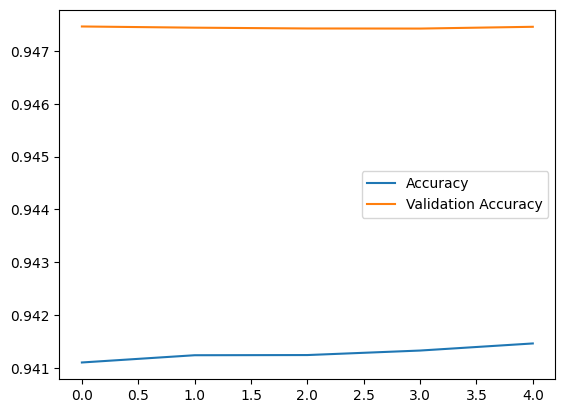

In [28]:
# Run training
if __name__ == "__main__":
    model, history = train_model()
    
    # Save the model
    model.save("deeplabv3plus_bund_segmentation.h5")
    
    # Plot training history
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.show()

29/29 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step


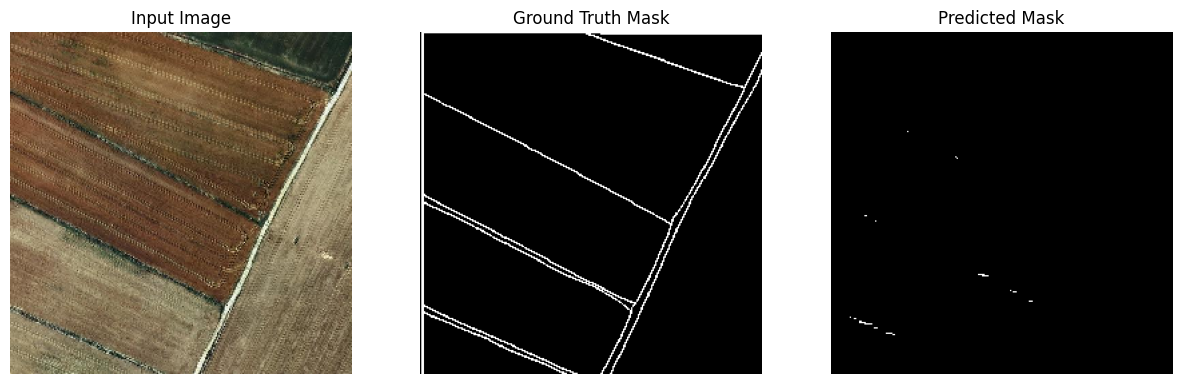

In [30]:
import matplotlib.pyplot as plt

def visualize_prediction(image, true_mask, pred_mask, image_index=0):
    """
    Visualize input image, ground truth mask, and predicted mask side-by-side.

    Parameters:
        image: Array of input images.
        true_mask: Array of ground truth masks.
        pred_mask: Array of predicted masks.
        image_index: Index of the image to visualize.
    """
    # Retrieve the specific image, ground truth mask, and predicted mask
    img = image[image_index]
    true_msk = true_mask[image_index]
    pred_msk = pred_mask[image_index]
    
    # Ensure masks are argmax-ed if in one-hot format
    if true_msk.ndim == 3:
        true_msk = true_msk.argmax(axis=-1)
    if pred_msk.ndim == 3:
        pred_msk = pred_msk.argmax(axis=-1)
    
    # Plot the images
    plt.figure(figsize=(15, 5))
    
    # Display the input image
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Input Image")
    plt.axis("off")
    
    # Display the true mask
    plt.subplot(1, 3, 2)
    plt.imshow(true_msk, cmap="gray")
    plt.title("Ground Truth Mask")
    plt.axis("off")
    
    # Display the predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(pred_msk, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")
    
    plt.show()

# Example usage
if __name__ == "__main__":
    # Example prediction (replace this with your trained model's predictions)
    X, Y = load_data(train_nir, train_mask)  # Load data
    #model, _ = train_model()  # Train your model
    predictions = model.predict(X)  # Predict
    
    # Visualize the first image, ground truth mask, and predicted mask
    visualize_prediction(X, Y, predictions, image_index=0)


29/29 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step


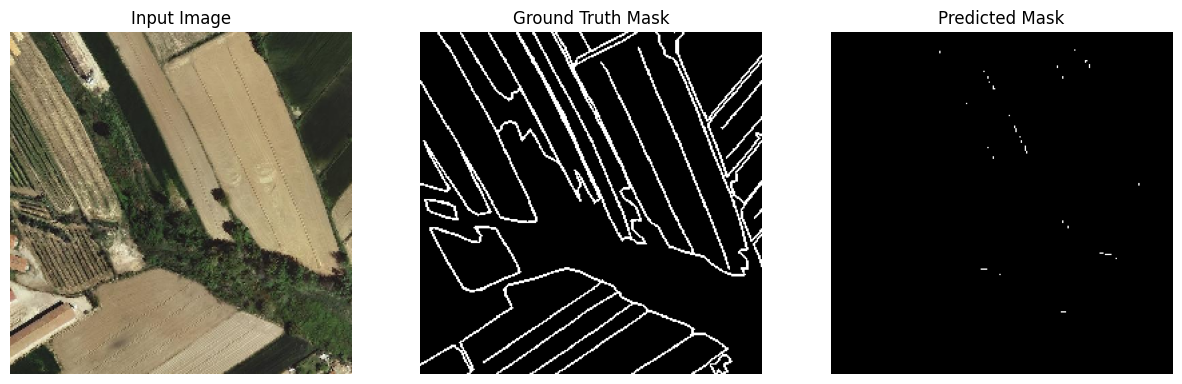

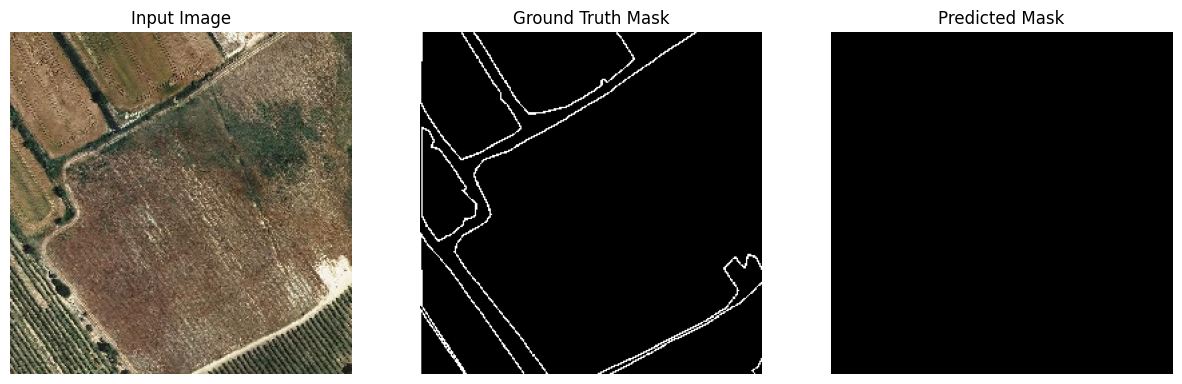

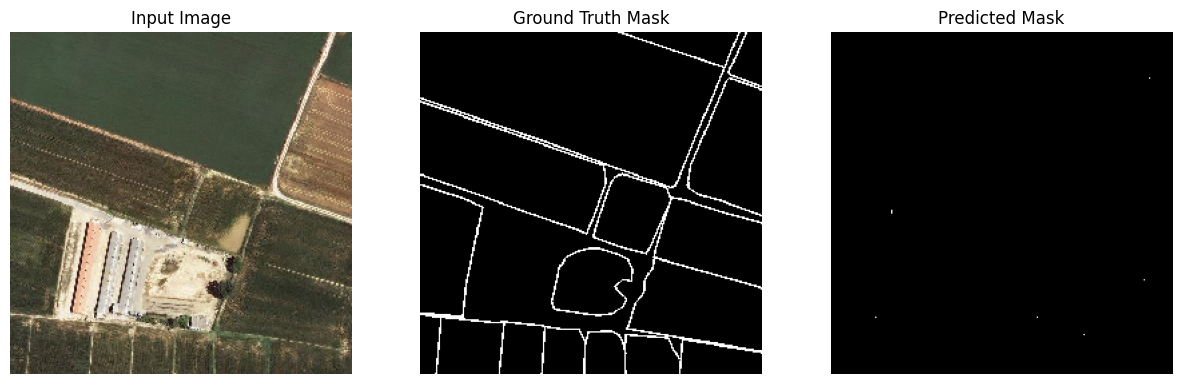

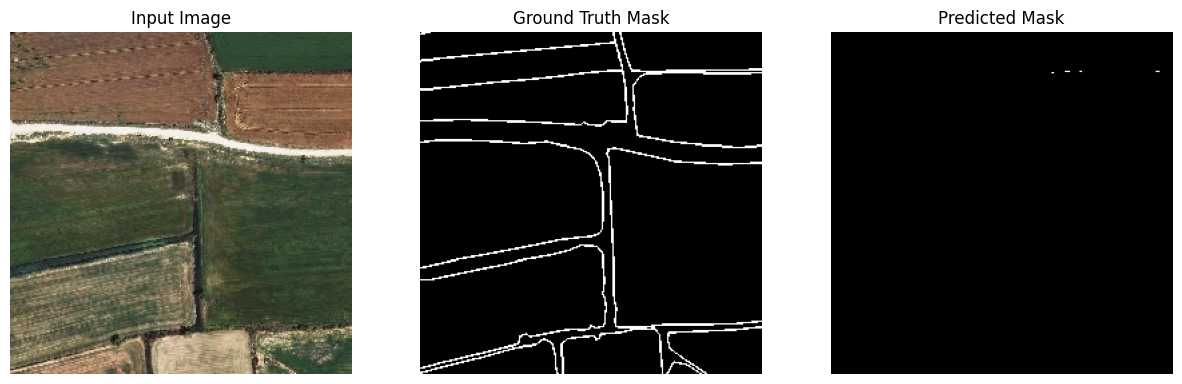

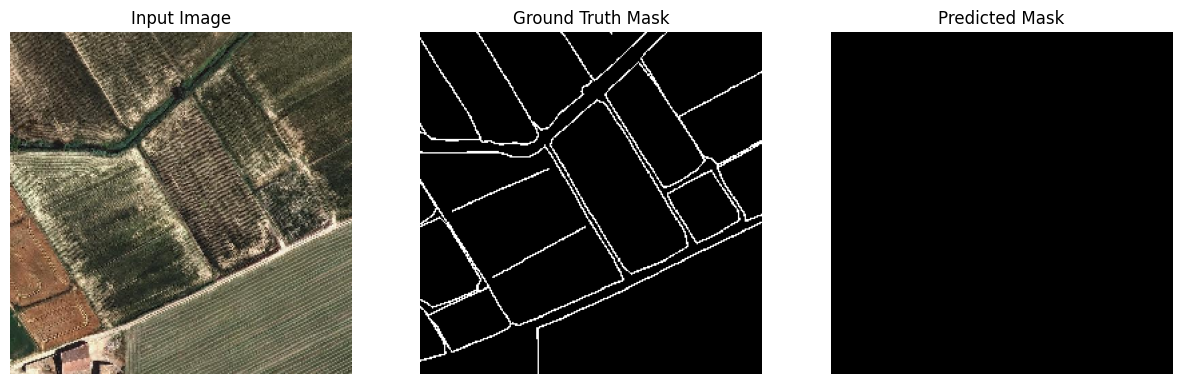

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_prediction(image, true_mask, pred_mask, image_index):
    """
    Visualize input image, ground truth mask, and predicted mask side-by-side.

    Parameters:
        image: Array of input images.
        true_mask: Array of ground truth masks.
        pred_mask: Array of predicted masks.
        image_index: Index of the image to visualize.
    """
    # Retrieve the specific image, ground truth mask, and predicted mask
    img = image[image_index]
    true_msk = true_mask[image_index]
    pred_msk = pred_mask[image_index]
    
    # Ensure masks are argmax-ed if in one-hot format
    if true_msk.ndim == 3:
        true_msk = true_msk.argmax(axis=-1)
    if pred_msk.ndim == 3:
        pred_msk = pred_msk.argmax(axis=-1)
    
    # Plot the images
    plt.figure(figsize=(15, 5))
    
    # Display the input image
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Input Image")
    plt.axis("off")
    
    # Display the true mask
    plt.subplot(1, 3, 2)
    plt.imshow(true_msk, cmap="gray")
    plt.title("Ground Truth Mask")
    plt.axis("off")
    
    # Display the predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(pred_msk, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")
    
    plt.show()

# Example usage
if __name__ == "__main__":
    # Replace with actual data loading
    X, Y = load_data(train_nir, train_mask)  # Load data
    predictions = model.predict(X)  # Predict masks with your trained model

    # Select 5 random indices
    random_indices = np.random.choice(X.shape[0], 5, replace=False)

    # Visualize predictions for the 5 random images
    for idx in random_indices:
        visualize_prediction(X, Y, predictions, image_index=idx)
